In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df_00 = pd.read_csv("dataset-of-00s.csv")
df_10 = pd.read_csv("dataset-of-10s.csv")
df_60 = pd.read_csv("dataset-of-60s.csv")
df_70 = pd.read_csv("dataset-of-70s.csv")
df_80 = pd.read_csv("dataset-of-80s.csv")
df_90 = pd.read_csv("dataset-of-90s.csv")

df = pd.concat([df_00, df_10, df_60, df_70, df_80, df_90])
df = df.drop(axis=1, labels='time_signature')
#Scaling the data
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()

df_X = df.iloc[:,3:17]


df_scaled = scale.fit_transform(df_X)
df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = df_X.columns
df_scaled


df_clean= df_scaled
for col in df_clean.columns:
  q1=df_clean[col].quantile(0.25)
  q3=df_clean[col].quantile(0.75)
  inq=q3-q1
  filter=(df_clean[col] >= q1-1.5*inq) & (df_clean[col] <= q3+1.5*inq)
  df_clean[col] = df_clean[col].loc[filter]
#Removing outliers

df_clean = df_clean.drop(axis=1, labels=['speechiness', 'instrumentalness'])

df_remove = df_clean.dropna()
#Removing missing values
df_remove.shape
#The number of songs remaining is 33401
df_merge = df.iloc[df_remove.index]
df_merge = df_merge.drop(axis=1, labels=['speechiness', 'instrumentalness'])
df_merge.columns
#Removed the predictors that were not used from the original dataset

#observations in each class
df_merge.groupby('target')[['danceability', 'energy', 'key', 'loudness',
       'mode', 'acousticness', 'liveness', 'valence', 'tempo', 'duration_ms',
       'chorus_hit', 'sections']].count()


df_merge.iloc[:,3:15]
#creating final scaled data with all the variables
scale = StandardScaler()
scale_X = scale.fit_transform(df_merge.iloc[:,3:15])
df_merge.iloc[:,3:15] = scale_X

X = df_merge.iloc[:,3:15]
X.shape

y = df_merge['target']
y.shape

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=True, random_state=1)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

X_train_final, X_valid, y_train_final, y_valid = train_test_split(X_train, y_train, test_size=0.25, random_state=42)
print(X_train_final)

(26720, 12) (6681, 12) (26720,) (6681,)
      danceability    energy       key  loudness      mode  acousticness  \
4293     -0.064347  1.007892 -0.339478  1.524700  0.651748      0.133834   
1764     -0.347443  1.646478 -0.904754  1.164583  0.651748     -0.775594   
5740      0.372093  0.483490  1.638992  1.050279  0.651748     -1.025205   
5845     -1.403157 -0.616063  1.073715  0.177796  0.651748     -0.108150   
8182     -0.813373 -1.385750  1.073715 -0.540789  0.651748      1.582670   
...            ...       ...       ...       ...       ...           ...   
3864     -1.379565 -0.937471 -0.339478 -0.849293 -1.534336     -0.729955   
7255      0.147975  0.796439 -1.187393  1.124518  0.651748     -0.334817   
5487      1.392419 -0.704873  1.638992 -1.402667  0.651748     -0.031573   
2093      1.244973  1.287009 -1.187393  0.045580  0.651748     -0.699324   
5566      0.006427  1.274322  1.356353  1.005029  0.651748     -0.891379   

      liveness   valence     tempo  duration_ms

In [3]:
print(type(X_train_final))
print(type(y_train_final))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>


In [4]:
import numpy as np
import pandas as pd

class DecisionNode:
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, value=None):
        # For decision node
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        # For leaf node
        self.value = value

def calculate_gini(y):
    """Calculate the Gini Impurity for a label set."""
    if len(y) == 0:
        return 0
    classes, counts = np.unique(y, return_counts=True)
    probabilities = counts / counts.sum()
    gini = 1 - np.sum(probabilities ** 2)
    return gini

def split_dataset(X, y, feature_index, threshold):
    """Split the dataset based on the given feature index and threshold."""
    left_indices = np.where(X[:, feature_index] <= threshold)
    right_indices = np.where(X[:, feature_index] > threshold)
    return X[left_indices], X[right_indices], y[left_indices], y[right_indices]

def get_best_split(X, y):
    """Find the best feature and threshold to split on."""
    best_gini = 1
    best_index = None
    best_threshold = None
    for feature_index in range(X.shape[1]):
        thresholds = np.unique(X[:, feature_index])
        for threshold in thresholds:
            _, _, y_left, y_right = split_dataset(X, y, feature_index, threshold)
            gini_left = calculate_gini(y_left)
            gini_right = calculate_gini(y_right)
            # Weighted Gini score for the split
            gini = (len(y_left) * gini_left + len(y_right) * gini_right) / len(y)
            if gini < best_gini:
                best_gini, best_index, best_threshold = gini, feature_index, threshold
    return best_index, best_threshold

def build_tree(X, y, max_depth, current_depth=0):
    """Recursively build the decision tree."""
    # Stopping criteria
    if len(np.unique(y)) == 1 or current_depth == max_depth:
        leaf_value = np.round(np.mean(y)).astype(int)
        return DecisionNode(value=leaf_value)
    
    feature_index, threshold = get_best_split(X, y)
    if feature_index is None:
        return DecisionNode(value=np.round(np.mean(y)).astype(int))
    
    X_left, X_right, y_left, y_right = split_dataset(X, y, feature_index, threshold)
    
    left_subtree = build_tree(X_left, y_left, max_depth, current_depth+1)
    right_subtree = build_tree(X_right, y_right, max_depth, current_depth+1)
    
    return DecisionNode(feature_index, threshold, left_subtree, right_subtree)

def predict(node, X):
    """Predict a label for a single datum."""
    if node.value is not None:
        return node.value
    if X[node.feature_index] <= node.threshold:
        return predict(node.left, X)
    return predict(node.right, X)

def predict_batch(node, X):
    """Predict labels for a batch of data."""
    return np.array([predict(node, datum) for datum in X])



In [5]:
#Convert your DataFrame and Series to numpy arrays for this implementation
X_train, y_train = X_train_final.values, y_train_final.values
tree = build_tree(X_train, y_train, max_depth=3)


In [6]:
# Predict labels for the validation dataset
predictions_valid = predict_batch(tree, X_valid.values)
# Predict labels for the test dataset
test_predictions = predict_batch(tree, X_test.values)

In [7]:
def calculate_accuracy(y_true, y_pred):
    correct_predictions = np.sum(y_true == y_pred)
    total_predictions = len(y_true)
    accuracy = correct_predictions / total_predictions
    return accuracy

# Calculate accuracy on the validation set
accuracy_valid = calculate_accuracy(y_valid, predictions_valid)
print(f'Validation Accuracy: {accuracy_valid * 100:.2f}%')

# Calculate accuracy for the test dataset
test_accuracy = calculate_accuracy(y_test, test_predictions)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")



Validation Accuracy: 66.78%
Test Accuracy: 67.46%


In [8]:
def create_confusion_matrix(y_true, y_pred):
    """Create a confusion matrix from true labels and predictions."""
    TP = np.sum((y_true == 1) & (y_pred == 1))
    TN = np.sum((y_true == 0) & (y_pred == 0))
    FP = np.sum((y_true == 0) & (y_pred == 1))
    FN = np.sum((y_true == 1) & (y_pred == 0))
    
    confusion_matrix = np.array([[TP, FP], 
                                 [FN, TN]])
    return confusion_matrix

# Create confusion matrix for the test dataset
test_confusion_matrix = create_confusion_matrix(y_test, test_predictions)
print("Confusion Matrix for Test Data:")
print(test_confusion_matrix)

# Create confusion matrix for the validation dataset
val_confusion_matrix = create_confusion_matrix(y_valid, predictions_valid)
print("\nConfusion Matrix for Validation Data:")
print(val_confusion_matrix)


Confusion Matrix for Test Data:
[[2637 1205]
 [ 969 1870]]

Confusion Matrix for Validation Data:
[[2664 1226]
 [ 993 1797]]


Graphical visualization of accuracy of the model 

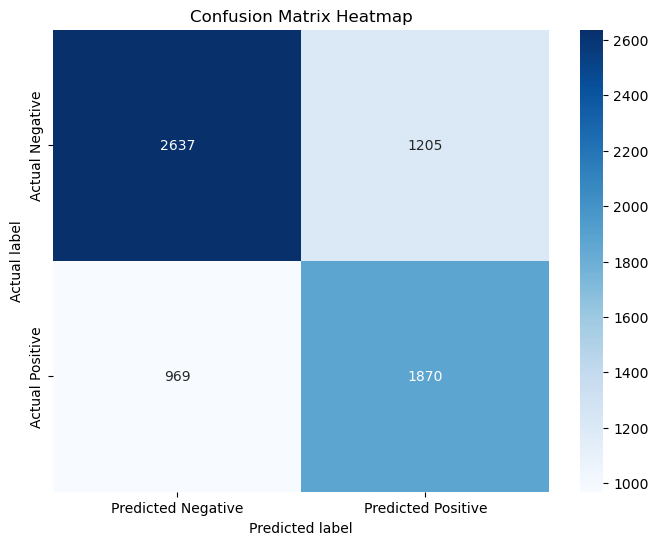

In [9]:
import seaborn as sns

# Assuming test_confusion_matrix is your confusion matrix for test data
plt.figure(figsize=(8, 6))
sns.heatmap(test_confusion_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted Negative', 'Predicted Positive'], 
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix Heatmap')
plt.show()


Validation Set Performance:
Accuracy: 0.6452095808383234
Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.61      0.61      3023
           1       0.68      0.67      0.68      3657

    accuracy                           0.65      6680
   macro avg       0.64      0.64      0.64      6680
weighted avg       0.65      0.65      0.65      6680

Confusion Matrix:
[[1842 1181]
 [1189 2468]]


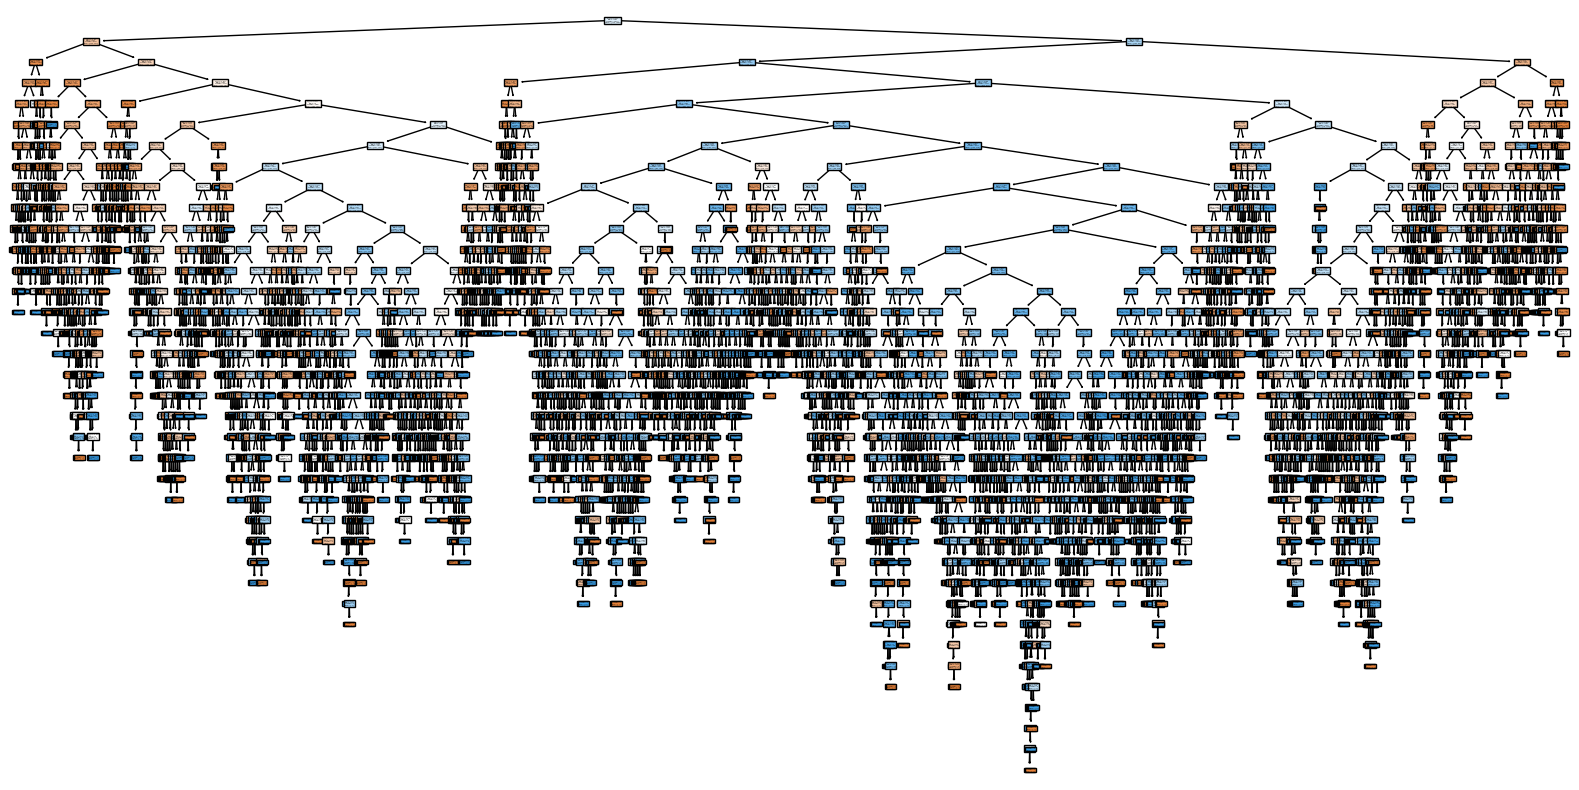

In [10]:
from sklearn.tree import DecisionTreeClassifier

# Initialize the DecisionTreeClassifier
# You can specify various parameters such as `max_depth`, `criterion`, `min_samples_split`, etc.
# Here we'll use the default parameters to start with
dt_classifier = DecisionTreeClassifier(random_state=42)

# Fit the model on the final training set
dt_classifier.fit(X_train_final, y_train_final)

# Predict on the validation set
y_valid_pred = dt_classifier.predict(X_valid)

# Evaluate the performance on the validation set
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print("Validation Set Performance:")
print("Accuracy:", accuracy_score(y_valid, y_valid_pred))
print("Classification Report:")
print(classification_report(y_valid, y_valid_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_valid, y_valid_pred))

# You can also visualize the tree using the following code
# Note: You'll need to install the required packages for visualization such as graphviz
from sklearn import tree
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
tree.plot_tree(dt_classifier, filled=True)
plt.show()
